### Notebook to run unit tests.

Run this before deployments!

In [4]:
import satellite_images_nso.api.nso_georegion as nso
from settings import nso_username, nso_password
import os
# Optional
from settings import height_band_filepath, cloud_detection_model_path, links_must_contain
import rasterio
from rasterio.plot import show
import satellite_images_nso._manipulation.nso_manipulator as nso_manipulator
import matplotlib.pyplot as plt
from cloud_recognition.api import detect_clouds
import pickle
import numpy as np
import glob

In [9]:
def plot_nso_tif(filepath):

    src = rasterio.open(filepath)
    plot_out_image = (
            np.clip(src.read()[2::-1], 0, 2200) / 2200
        )  # out_image[2::-1] selects the first three items, reversed

    plt.figure(figsize=(10, 10))
    rasterio.plot.show(plot_out_image, transform=src.transform)
    src.close()


# Link tests

In [4]:
# Test Coepelduynen because it is easy region to download and test.
path_geojson = "C:/repos/satellite-images-nso/input_data/natura2000_coepelduynen.geojson"
output_path = "E:/data/test"

georegion = nso.nso_georegion(
    path_to_geojson=path_geojson, 
    output_folder=output_path,
    username=nso_username,
    password=nso_password,
    )

C:/repos/satellite-images-nso/input_data/natura2000_coepelduynen.geojson: No such file or directory


Exception: Geojson not loaded correctly. Weirdly this error is sometimes solved by reloading the session

In [3]:
# Test if links are found
links = georegion.retrieve_download_links(max_diff=0.5, start_date="2019-01-01")

assert len(links) >0, "No links found error!"

# Columns to check for existence
columns_to_check = ['link', 'percentage_geojson', 'missing_polygon', 'covered_polygon']

# Check if columns exist
existing_columns = [col for col in columns_to_check if col in links.columns]

assert len(existing_columns) == len(columns_to_check), "Certain columns are not in the links"

NameError: name 'georegion' is not defined

In [42]:
links

,link,percentage_geojson,missing_polygon,covered_polygon,date,satellite,resolution
0,https://api.satellietdataportaal.nl/v1/downloa...,0.998066,POLYGON EMPTY,POLYGON ((4.434368936936583 52.237377749025185...,20220816,SV2-01,200cm
1,https://api.satellietdataportaal.nl/v1/downloa...,0.998066,POLYGON EMPTY,POLYGON ((4.434368936936583 52.237377749025185...,20220816,SV2-01,50cm
2,https://api.satellietdataportaal.nl/v1/downloa...,0.998066,POLYGON EMPTY,POLYGON ((4.434368936936583 52.237377749025185...,20220816,SV2-01,50cm
3,https://api.satellietdataportaal.nl/v1/downloa...,0.998066,POLYGON EMPTY,POLYGON ((4.434368936936583 52.237377749025185...,20220816,SV2-01,50cm
4,https://api.satellietdataportaal.nl/v1/downloa...,0.998066,POLYGON EMPTY,POLYGON ((4.434368936936583 52.237377749025185...,20220816,SV2-01,None
...,...,...,...,...,...,...,...
491,https://api.satellietdataportaal.nl/v1/downloa...,0.998066,POLYGON EMPTY,POLYGON ((4.434368936936583 52.237377749025185...,20231128,SVNEO-01,120cm
492,https://api.satellietdataportaal.nl/v1/downloa...,0.998066,POLYGON EMPTY,POLYGON ((4.434368936936583 52.237377749025185...,20231128,SVNEO-01,30cm
493,https://api.satellietdataportaal.nl/v1/downloa...,0.998066,POLYGON EMPTY,POLYGON ((4.434368936936583 52.237377749025185...,20231128,SVNEO-01,30cm
494,https://api.satellietdataportaal.nl/v1/downloa...,0.998066,POLYGON EMPTY,POLYGON ((4.434368936936583 52.237377749025185...,20231128,SVNEO-01,30cm


# PNEO test

In [43]:
# Test if PNEO links are found
pneo_links = links[links['resolution'] == "30cm"]
pneo_links = pneo_links[pneo_links["link"].str.contains("RGBNED")]
pneo_links = pneo_links.sort_values("percentage_geojson")


assert len(pneo_links) >0, "No PNEO links found error!"

In [44]:
filepath = georegion.execute_link(pneo_links[0:1]["link"].values[0])

assert filepath, "No file has been downloaded or extracted for PNEO!"

Searching for: E:/data/test\20230601_105710_PNEO-04_1_1**natura2000_coepelduynen*cropped*.tif
Found files: ['E:/data/test\\20230601_105710_PNEO-04_1_1_30cm_RD_12bit_RGBNED_Rijnsburg_natura2000_coepelduynen_cropped.tif', 'E:/data/test\\20230601_105710_PNEO-04_1_1_30cm_RD_12bit_RGBNED_Rijnsburg_natura2000_coepelduynen_cropped_ndwi.tif']
File is already cropped
E:/data/test\20230601_105710_PNEO-04_1_1_30cm_RD_12bit_RGBNED_Rijnsburg_natura2000_coepelduynen_cropped_ndwi.tif is Ready


In [45]:
# Remove the file for later tests
os.remove(filepath)

# Superview test

In [46]:
# Example filter on resolution and bands
superview_links = links[links['resolution'] == "50cm"]
superview_links = superview_links[superview_links["link"].str.contains("RGBI")]
superview_links = superview_links.sort_values("percentage_geojson")

assert len(superview_links) >0, "No  PNEO links found error!"

In [47]:
filepath = georegion.execute_link(superview_links[0:1]["link"].values[0])

assert filepath, "No file has been downloaded or extracted for Superview!"

# Remove the file for later tests
os.remove(filepath)

Searching for: E:/data/test\20210302_111245_SV1-03**natura2000_coepelduynen*cropped*.tif
Found files: ['E:/data/test\\20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm_NoordwijkAanZee_natura2000_coepelduynen_cropped.tif']
File is already cropped
E:/data/test\20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm_NoordwijkAanZee_natura2000_coepelduynen_cropped.tif is Ready


# Multipolygon test

In [48]:
# Test Coepelduynen because it is easy region to download and test.
path_geojson = "C:/repos/satellite-images-nso/input_data/natura2000_solleveld_kapittelduinen.geojson"
output_path = "E:/data/test"

georegion = nso.nso_georegion(
    path_to_geojson=path_geojson, 
    output_folder=output_path,
    username=nso_username,
    password=nso_password,
    )

# Test if links are found
links = georegion.retrieve_download_links(max_diff=0.5, start_date="2019-01-01")

Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.162003  4.162148  4.162467  4.1625    4.162815  4.163475  4.163721
   4.164293  4.164899  4.165279  4.166971  4.168162  4.169145  4.169155
   4.16941   4.170454  4.171146  4.171605  4.171802  4.171927  4.172009
   4.172094  4.172096  4.172155  4.172203  4.172347  4.17254   4.172727
   4.172808  4.172931  4.172969  4.172997  4.173185  4.173959  4.17411
   4.17391   4.173802  4.17384   4.173852  4.173837  4.173741  4.173701
   4.173138  4.172859  4.172974  4.17318   4.173366  4.173663  4.173819
   4.173829  4.174207  4.174224  4.174543  4.174732  4.175494  4.175651
   4.17587   4.176203  4.176315  4.176463  4.176658  4.176758  4.176946
   4.177216  4.177235  4.177278  4.177304  4.177315  4.179543  4.17993
   4.180087  4.180267  4.180477  4.180758  4.181315  4.181415  4.181486
   4.181666  4.181956  4.182378  4.182955  4.183154  4.183383  4.183645
   4.183658  4.18376   4.183804  4.183892  4.184047  

Searching for: E:/data/test\20240318_105326_PNEO-04_1_1**natura2000_solleveld_kapittelduinen*cropped*.tif
Found files: []
Zip file found skipping download
Extracting files
Extracted folder is: E:/data/test/20240318_105326_PNEO-04_1_1_30cm_RGBNED_12bit_PNEO
cropping file E:/data/test/20240318_105326_PNEO-04_1_1_30cm_RGBNED_12bit_PNEO\20240318_105326_PNEO-04_1_1_30cm_RD_12bit_RGBNED_DeLier\20240318_105326_PNEO-04_1_1_30cm_RD_12bit_RGBNED_DeLier.tif
New cropped filename: E:/data/test/20240318_105326_PNEO-04_1_1_30cm_RGBNED_12bit_PNEO\20240318_105326_PNEO-04_1_1_30cm_RD_12bit_RGBNED_DeLier\20240318_105326_PNEO-04_1_1_30cm_RD_12bit_RGBNED_DeLier_natura2000_solleveld_kapittelduinen_cropped.tif
raster path opened
Assuming PNEO Satellite columns
convert to RD
Plotting data for:E:/data/test/20240318_105326_PNEO-04_1_1_30cm_RGBNED_12bit_PNEO\20240318_105326_PNEO-04_1_1_30cm_RD_12bit_RGBNED_DeLier\20240318_105326_PNEO-04_1_1_30cm_RD_12bit_RGBNED_DeLier_natura2000_solleveld_kapittelduinen_cropped.

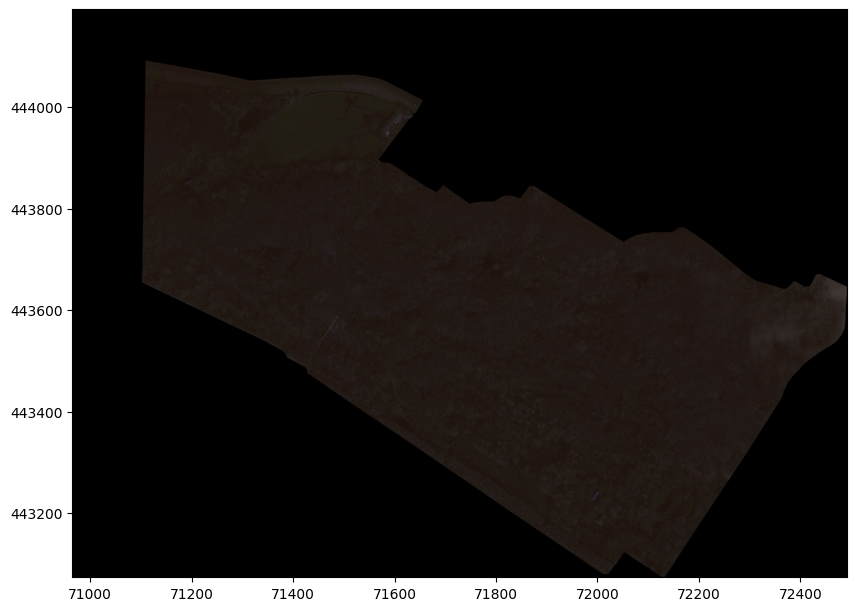

finished cropping E:/data/test/20240318_105326_PNEO-04_1_1_30cm_RGBNED_12bit_PNEO\20240318_105326_PNEO-04_1_1_30cm_RD_12bit_RGBNED_DeLier\20240318_105326_PNEO-04_1_1_30cm_RD_12bit_RGBNED_DeLier.tif
Cropped file is found at: E:/data/test/20240318_105326_PNEO-04_1_1_30cm_RD_12bit_RGBNED_DeLier_natura2000_solleveld_kapittelduinen_cropped.tif
Succesfully cropped .tif file
E:/data/test/20240318_105326_PNEO-04_1_1_30cm_RD_12bit_RGBNED_DeLier_natura2000_solleveld_kapittelduinen_cropped.tif is Ready


In [49]:
# Test if PNEO links are found
pneo_links = links[links['resolution'] == "30cm"]
pneo_links = pneo_links[pneo_links["link"].str.contains("RGBNED")]
pneo_links = pneo_links.sort_values("percentage_geojson")


filepath = georegion.execute_link(pneo_links[1:2]["link"].values[0])

assert filepath, "No file has been downloaded or extracted for PNEO multipolygon!"

# Remove the file for later tests
os.remove(filepath)

# Check re_ndvi, ndvi, ndwi channels on PNEO

In [50]:
# Test re_ndvi on PNEO coepelduynen and see if gives the best results.
path_geojson = "C:/repos/satellite-images-nso/input_data/natura2000_coepelduynen.geojson"
output_path = "E:/data/test"

georegion = nso.nso_georegion(
    path_to_geojson=path_geojson, 
    output_folder=output_path,
    username=nso_username,
    password=nso_password,
    )

links = georegion.retrieve_download_links(max_diff=0.5, start_date="2019-01-01")

# Test if PNEO links are found
pneo_links = links[links['resolution'] == "30cm"]
pneo_links = pneo_links[pneo_links["link"].str.contains("RGBNED")]
pneo_links = pneo_links.sort_values("percentage_geojson")

filepath = georegion.execute_link(pneo_links[0:1]["link"].values[0], add_red_edge_ndvi_band= True)


Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.43428239  4.43436894  4.43436895 ...  4.43388158  4.4339625
   4.43428239]
 [52.23760322 52.23737775 52.23737772 ... 52.23755883 52.23755515
  52.23760322]]
Passed region check
Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.43428239  4.43436894  4.43436895 ...  4.43388158  4.4339625
   4.43428239]
 [52.23760322 52.23737775 52.23737772 ... 52.23755883 52.23755515
  52.23760322]]
Passed region check
Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.43428239  4.43436894  4.43436895 ...  4.43388158  4.4339625
   4.43428239]
 [52.23760322 52.23737775 52.23737772 ... 52.23755883 52.23755515
  52.23760322]]
Passed region check
Cloudcover check:
Passed cloud check
Going into region check:
Max_diff in method 0.5
[[ 4.43428239  4.43436894  4.43436895 ...  4.43388158  4.4339625
   4.43428239]
 [52.23760322 52.23737775 52.23737

c:\ProgramData\Anaconda3\envs\py310\envs\py312\Lib\site-packages\satellite_images_nso\_index_channels\calculate_index_channels.py:58: RuntimeWarning: invalid value encountered in divide
  re_ndvi = (red_edge - red) / (red_edge + red) * 100 + 100


Done with calculating re_ndvi channel
Saving to E:/data/test\20230601_105710_PNEO-04_1_1_30cm_RD_12bit_RGBNED_Rijnsburg_natura2000_coepelduynen_cropped_re_ndvi.tif


Number of bands: 7


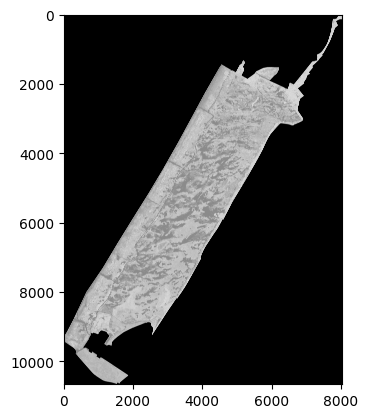

In [51]:
# Open the TIFF image and display ndvi
with rasterio.open(filepath) as src:
    # Get the number of bands
    num_bands = src.count
    print("Number of bands:", num_bands)

    assert num_bands >= 7, "re_ndvi bands not added correctly"
    
    # Read one of the bands (e.g., the first band)
    band = src.read(num_bands)  # Change the index to plot a different band
    show(band, cmap='gray')  # Adjust the colormap as needed

In [52]:
# Add the NDWI Channel
filepath_ndwi = nso_manipulator.add_index_channels(filepath, ["ndwi"])

Generating NDWI channel...


c:\ProgramData\Anaconda3\envs\py310\envs\py312\Lib\site-packages\satellite_images_nso\_index_channels\calculate_index_channels.py:75: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - near_infra_red) / (near_infra_red + green) * 100 + 100


Done with calculating ndwi channel
Saving to E:/data/test\20230601_105710_PNEO-04_1_1_30cm_RD_12bit_RGBNED_Rijnsburg_natura2000_coepelduynen_cropped_re_ndvi_ndwi.tif


In [53]:
# Open the TIFF image and display ndvi
with rasterio.open(filepath) as src:
    # Get the number of bands
    num_bands = src.count
    print("Number of bands:", num_bands)

    assert num_bands >= 8, "re_ndvi bands not added correctly"
    
    # Read one of the bands (e.g., the first band)
    band = src.read(num_bands)  # Change the index to plot a different band
    show(band, cmap='gray')  # Adjust the colormap as needed

Number of bands: 7


AssertionError: re_ndvi bands not added correctly

In [ ]:
# Remove them for further tests
os.remove(filepath_ndwi)
os.remove(filepath)

# Check re_ndvi, ndvi, ndwi channels on Superview

Searching for: E:/data/test\20210302_111245_SV1-03**natura2000_coepelduynen*cropped*.tif
Found files: []
Zip file found skipping download
Extracting files
Extracted folder is: E:/data/test/20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm
cropping file E:/data/test/20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm\20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm_NoordwijkAanZee.tif
New cropped filename: E:/data/test/20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm\20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm_NoordwijkAanZee_natura2000_coepelduynen_cropped.tif
raster path opened
Assuming Superview Satellite columns
convert to RD
Plotting data for:E:/data/test/20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm\20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm_NoordwijkAanZee_natura2000_coepelduynen_cropped.tif-----------------------------------------------------


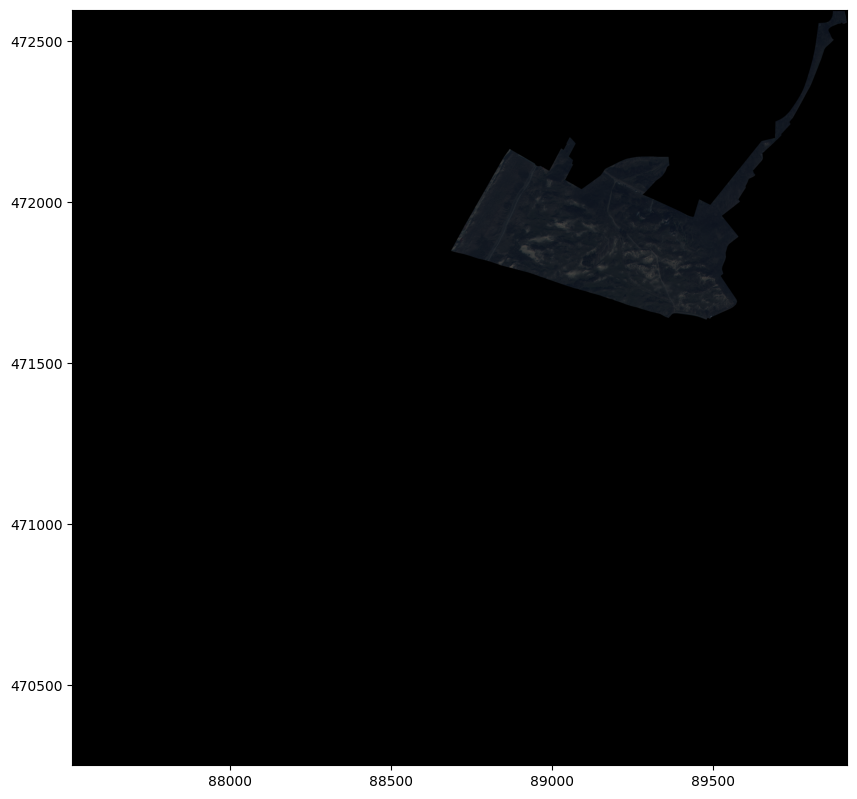

finished cropping E:/data/test/20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm\20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm_NoordwijkAanZee.tif
Cropped file is found at: E:/data/test/20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm_NoordwijkAanZee_natura2000_coepelduynen_cropped.tif
Succesfully cropped .tif file
E:/data/test/20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm_NoordwijkAanZee_natura2000_coepelduynen_cropped.tif is Ready
Generating NDVI channel...


c:\ProgramData\Anaconda3\envs\py310\envs\py312\Lib\site-packages\satellite_images_nso\_index_channels\calculate_index_channels.py:41: RuntimeWarning: invalid value encountered in divide
  ndvi = (near_infra_red - red) / (near_infra_red + red) * 100 + 100


Done with calculating ndvi channel
Saving to E:/data/test/20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm_NoordwijkAanZee_natura2000_coepelduynen_cropped_ndvi.tif


In [ ]:
# Test ndvi on superview satellite images
superview_links = links[links['resolution'] == "50cm"]
superview_links = superview_links[superview_links["link"].str.contains("RGBI")]
superview_links = superview_links.sort_values("percentage_geojson")
filepath = georegion.execute_link(superview_links[0:1]["link"].values[0], add_ndvi_band= True)

Number of bands: 5


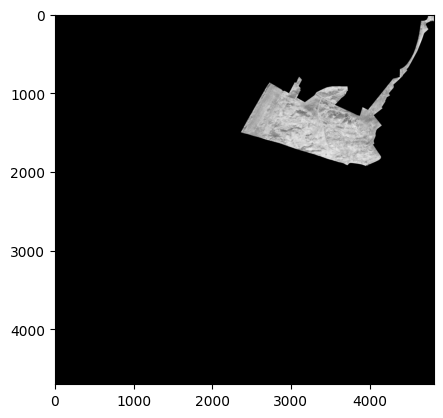

In [ ]:
# Open the TIFF image and display ndvi
with rasterio.open(filepath) as src:
        # Get the number of bands
        num_bands = src.count
        print("Number of bands:", num_bands)

        assert num_bands >= 5, "ndvi bands not added correctly"
        
        # Read one of the bands (e.g., the first band)
        band = src.read(num_bands)  # Change the index to plot a different band
        show(band, cmap='gray')

Generating NDWI channel...


c:\ProgramData\Anaconda3\envs\py310\envs\py312\Lib\site-packages\satellite_images_nso\_index_channels\calculate_index_channels.py:75: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - near_infra_red) / (near_infra_red + green) * 100 + 100


Done with calculating ndwi channel
Saving to E:/data/test/20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm_NoordwijkAanZee_natura2000_coepelduynen_cropped_ndvi_ndwi.tif
Number of bands: 6


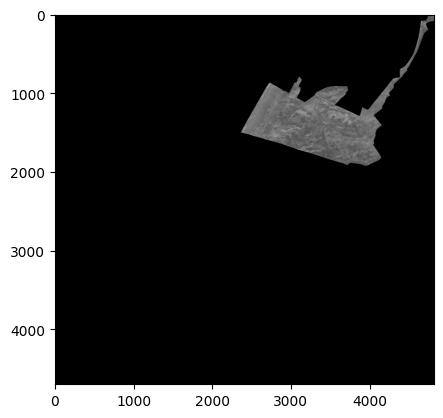

In [ ]:
# Add the NDWI Channel
filepath_ndwi = nso_manipulator.add_index_channels(filepath, ["ndwi"])


# Open the TIFF image and display ndvi
with rasterio.open(filepath_ndwi) as src:
    # Get the number of bands
    num_bands = src.count
    print("Number of bands:", num_bands)

    assert num_bands >= 6, "re_ndvi bands not added correctly"
    
    # Read one of the bands (e.g., the first band)
    band = src.read(num_bands)  # Change the index to plot a different band
    show(band, cmap='gray')  # Adjust the colormap as needed

In [ ]:
# Remove them for further tests
os.remove(filepath_ndwi)
os.remove(filepath)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'E:/data/test/20210302_111245_SV1-03_SV_RD_11bit_RGBI_50cm_NoordwijkAanZee_natura2000_coepelduynen_cropped_ndvi_ndwi.tif'

# Cloud detection tests

In [2]:
file_with_clouds = "E:/data/duinen_goeree_kwade_hoek/20230918_105252_PNEO-04_1_1_30cm_RD_12bit_RGBNED_TweedeMaasvlakte_Duinen_Goeree_Kwade_Hoek_cropped.tif"
path_to_model = pickle.load(open("C:/repos/satellite-images-nso/models/cloud_detection_logistic_regression_v1.0.sav", "rb"))

c:\ProgramData\Anaconda3\envs\py310\envs\py312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\ProgramData\Anaconda3\envs\py310\envs\py312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\ProgramData\Anaconda3\envs\py310\envs\py312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 

----------
E:/data/coepelduynen\20190302_105726_SV1-01_50cm_RD_11bit_RGBI_Warmond_natura2000_coepelduynen_cropped.tif


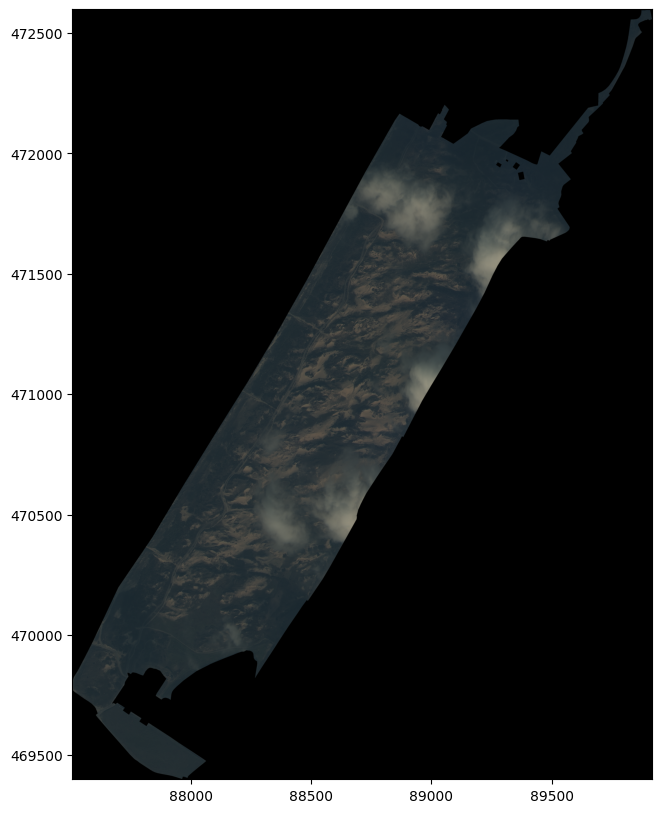

----------
E:/data/coepelduynen\20190302_105829_SV1-01_50cm_RD_11bit_RGBI_KatwijkAanZee_natura2000_coepelduynen_cropped.tif


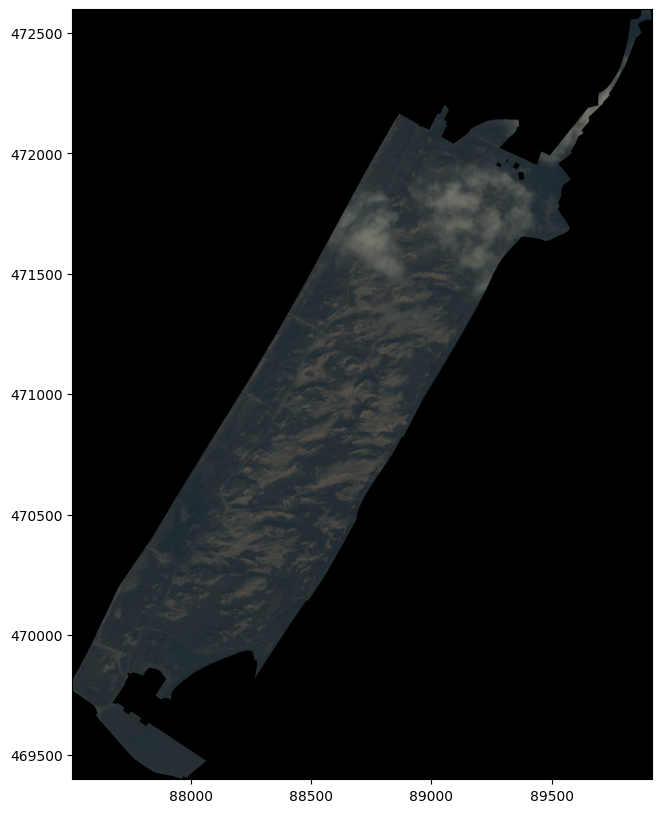

----------
E:/data/coepelduynen\20190308_111644_SV1-01_50cm_RD_11bit_RGBI_Oegstgeest_natura2000_coepelduynen_cropped.tif


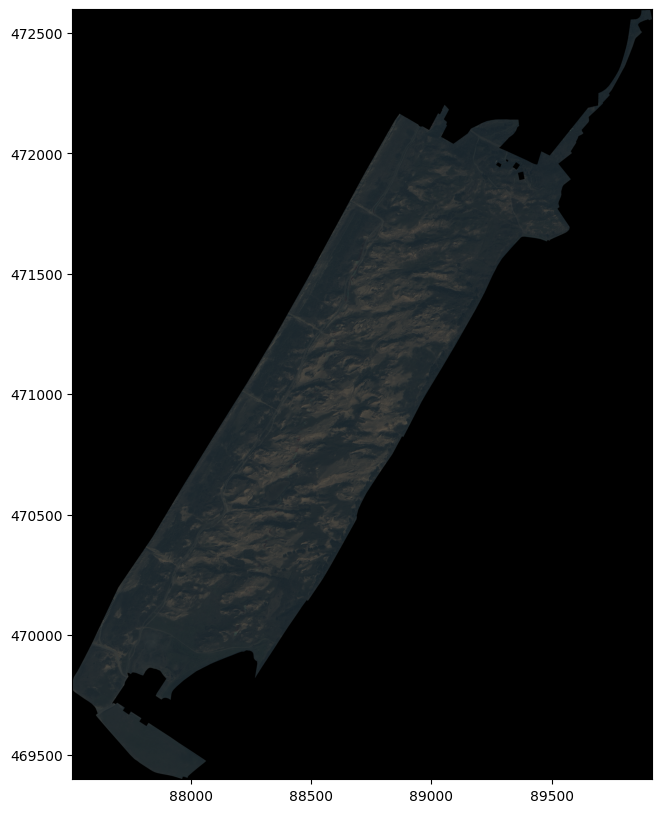

----------
E:/data/coepelduynen\20190422_111335_SV1-01_50cm_RD_11bit_RGBI_Oegstgeest_natura2000_coepelduynen_cropped.tif


In [11]:
for file in glob.glob("E:/data/coepelduynen/*cropped.tif"):
    print("----------")
    print(file)
    plot_nso_tif(file)

In [12]:
clouds = detect_clouds(
                model=path_to_model,
                filepath=file_with_clouds,
            )

In [13]:
clouds

True